## Import Packages

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.cluster import SilhouetteVisualizer
from kneed import KneeLocator
import os
import glob
import seaborn as sns

## Load Song Data

In [92]:
approach_name = "DiversifiedPlaylistApproach_no_accousticness_no_speechiness_KickOutliersRecluster"
#approach_name_collection = "DiversifiedPlaylistApproach_KickOutliersRecluster"
folder_path = "Song_Collection_" + approach_name + "\\*.csv"

#model_path = "Model_" + approach_name
model_path = "Model_" + approach_name
song_collection_path = "Song_Collection_" + approach_name

try:
    os.makedirs(model_path)
except FileExistsError:
    pass

### Load Song Collection from Master Dataframes

In [15]:
df_master = pd.read_csv(r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\Spotify_Song_Recommender\Song_Collection_DiversifiedPlaylistApproach\11137_Song_Collection.csv")
df_song_info = pd.read_csv(r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\Spotify_Song_Recommender\Song_Collection_DiversifiedPlaylistApproach\11137_Song_Infos.csv")

song_ids_master = list(df_master["id"])
song_ids_slave = list(df_song_info["id"])

df_combi = df_song_info[pd.DataFrame(df_song_info["id"].tolist()).isin(song_ids_master).any(1)].reset_index(drop=True)
df_complete = pd.concat([df_combi[["song_name", "song_artist"]], df_master], axis=1)
df_complete.drop_duplicates(inplace=True)
df_complete.dropna(inplace=True)
df_complete

,song_name,song_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,My Girl,The Temptations,0.604,0.648,-6.947,0.0343,0.04260,0.000000,0.1580,0.5230,109.969,5CoJZusX68O7syF5efY0pU,224880.0
1,When a Man Loves a Woman,Percy Sledge,0.420,0.361,-10.750,0.0341,0.41300,0.003040,0.0708,0.0843,112.260,1s65HRPwZtSG5dBIBZ0dix,396627.0
2,(I Can't Get No) Satisfaction - Mono Version,The Rolling Stones,0.439,0.981,-4.871,0.1270,0.00002,0.321000,0.2520,0.2190,157.019,6ULAF7fV7JPQPPHz1aP3vc,256267.0
3,(What A) Wonderful World,Sam Cooke,0.528,0.541,-5.492,0.0398,0.80400,0.000000,0.2160,0.3630,82.686,6wzMwD1OcvOGOUXfaUxrBq,208645.0
4,Brown Eyed Girl,Van Morrison,0.701,0.393,-9.868,0.1550,0.91900,0.384000,0.0964,0.7910,75.908,1xXydFs62EqOXFMPizVhn4,196640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11132,Lift Me Up (feat. Rob Halford of Judas Priest),Five Finger Death Punch,0.686,0.127,-14.361,0.0342,0.75400,0.000014,0.0573,0.3720,93.699,5jgFfDIR6FR0gvlA56Nakr,138387.0
11133,Custer,Slipknot,0.422,0.837,-9.280,0.0688,0.01410,0.029200,0.6720,0.7920,137.667,3Q6NUdGcNE9CZRG7U46Z3x,408200.0
11134,Toxicity,System Of A Down,0.509,0.393,-11.608,0.0250,0.02780,0.000000,0.2130,0.3050,88.495,1XniiWESJxq9mCuixUVNBK,292800.0
11135,Coming Undone,Korn,0.373,0.388,-9.310,0.0337,0.52500,0.000000,0.2670,0.6870,77.643,7rgUYidQh5tH0YlXCoKaYJ,181347.0


In [79]:
df_complete

,song_name,song_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,cluster
0,My Girl,The Temptations,0.604,0.648,-6.947,0.0343,0.04260,0.000000,0.1580,0.5230,109.969,5CoJZusX68O7syF5efY0pU,224880.0,7
1,When a Man Loves a Woman,Percy Sledge,0.420,0.361,-10.750,0.0341,0.41300,0.003040,0.0708,0.0843,112.260,1s65HRPwZtSG5dBIBZ0dix,396627.0,4
2,(I Can't Get No) Satisfaction - Mono Version,The Rolling Stones,0.439,0.981,-4.871,0.1270,0.00002,0.321000,0.2520,0.2190,157.019,6ULAF7fV7JPQPPHz1aP3vc,256267.0,0
3,(What A) Wonderful World,Sam Cooke,0.528,0.541,-5.492,0.0398,0.80400,0.000000,0.2160,0.3630,82.686,6wzMwD1OcvOGOUXfaUxrBq,208645.0,1
4,Brown Eyed Girl,Van Morrison,0.701,0.393,-9.868,0.1550,0.91900,0.384000,0.0964,0.7910,75.908,1xXydFs62EqOXFMPizVhn4,196640.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11132,Lift Me Up (feat. Rob Halford of Judas Priest),Five Finger Death Punch,0.686,0.127,-14.361,0.0342,0.75400,0.000014,0.0573,0.3720,93.699,5jgFfDIR6FR0gvlA56Nakr,138387.0,1
11133,Custer,Slipknot,0.422,0.837,-9.280,0.0688,0.01410,0.029200,0.6720,0.7920,137.667,3Q6NUdGcNE9CZRG7U46Z3x,408200.0,8
11134,Toxicity,System Of A Down,0.509,0.393,-11.608,0.0250,0.02780,0.000000,0.2130,0.3050,88.495,1XniiWESJxq9mCuixUVNBK,292800.0,6
11135,Coming Undone,Korn,0.373,0.388,-9.310,0.0337,0.52500,0.000000,0.2670,0.6870,77.643,7rgUYidQh5tH0YlXCoKaYJ,181347.0,1


## K Means - Initial Training

### Create Scaler

In [80]:
X = df_complete[['danceability', 'energy', 'loudness', 'liveness', 'valence', 
                 'tempo', 'acousticness']] # ,'speechiness', 'instrumentalness

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled_df

,danceability,energy,loudness,liveness,valence,tempo,acousticness
0,0.076877,0.171279,0.255560,-0.145459,0.297302,-0.388601,-0.793888
1,-1.007770,-1.044573,-0.618791,-0.758819,-1.507089,-0.312794,0.379951
2,-0.895768,1.582006,0.732855,0.515733,-0.953062,1.168243,-0.928828
3,-0.371129,-0.282018,0.590080,0.262510,-0.360785,-1.291373,1.619074
4,0.648675,-0.909008,-0.416009,-0.578750,1.399597,-1.515651,1.983522
...,...,...,...,...,...,...,...
11132,0.560253,-2.035895,-1.448999,-0.853777,-0.323767,-0.926962,1.460619
11133,-0.995980,0.971962,-0.280822,3.469991,1.403710,0.527902,-0.884207
11134,-0.483131,-0.909008,-0.816054,0.241409,-0.599341,-1.099158,-0.840791
11135,-1.284826,-0.930190,-0.287719,0.621242,0.971840,-1.458241,0.734892


#### Elbow

Optimal number of clusters 9


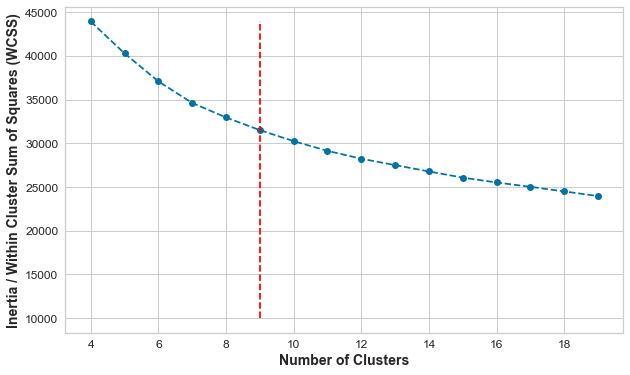

In [12]:
K = list(range(4,20))
inertia = []

for k in K:
    #print("Training a K-Means model with {} clusters! ".format(k))
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

cluster_count = KneeLocator(K, inertia, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", cluster_count)
    
fig = plt.figure(figsize=(10,6))
plt.plot(K, inertia, marker='o', linestyle='--')
plt.vlines(cluster_count, ymin=10000 , ymax=max(inertia), linestyles='dashed', color="red")
plt.xlabel('Number of Clusters', weight="bold", fontsize=14)
plt.ylabel('Inertia / Within Cluster Sum of Squares (WCSS)', weight="bold", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Reintroducing Clusters into original Dataframe

### Choosing Optimal K = 8 to predict clusters

In [16]:
kmeans = KMeans(n_clusters = cluster_count, random_state = 1234)
kmeans.fit(X_scaled_df)
clusters = kmeans.predict(X_scaled_df)

In [17]:
df_complete["cluster"] = clusters

In [18]:
song_collection_clustered_title = model_path + "/" + str(len(df_complete)) + "_Song_Collection_CLUSTERED.csv"
df_complete.to_csv(song_collection_clustered_title, index=False)

## Audio Features Investigation

### Checking Audio Features Correlation

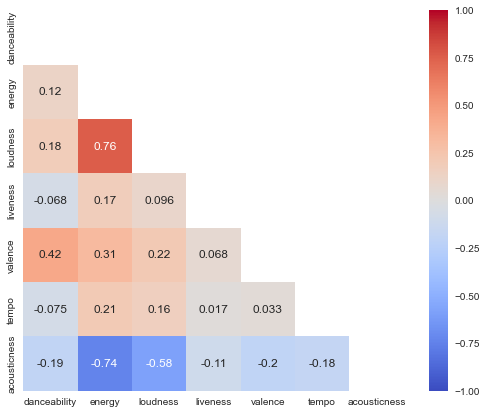

In [19]:
corr = X_scaled_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

### Checking Audio Features Distribution

DANCEABILITY


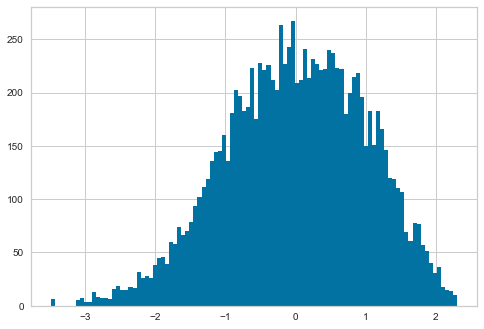

ENERGY


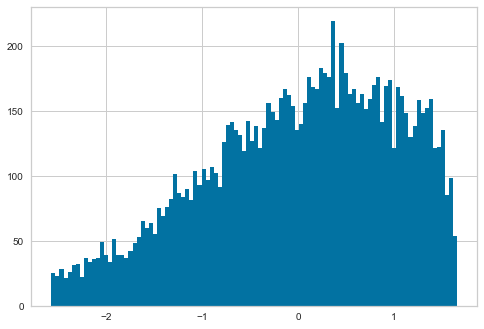

LOUDNESS


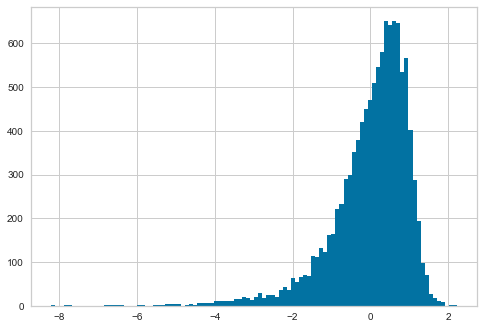

LIVENESS


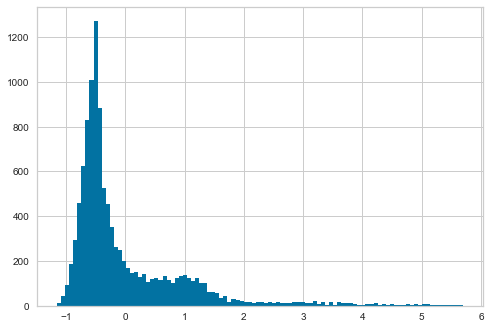

VALENCE


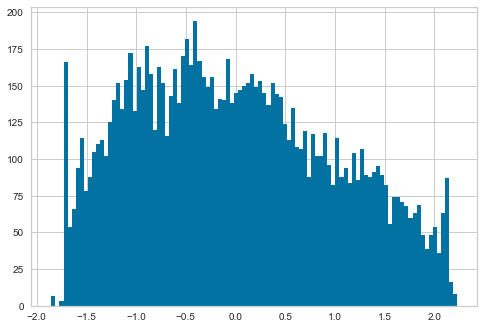

TEMPO


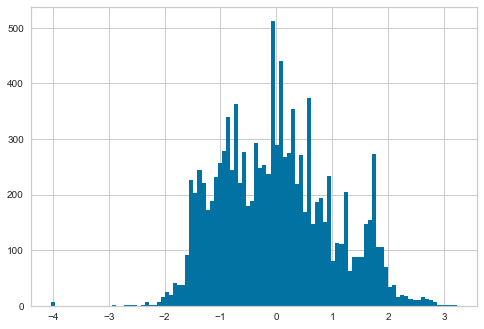

ACOUSTICNESS


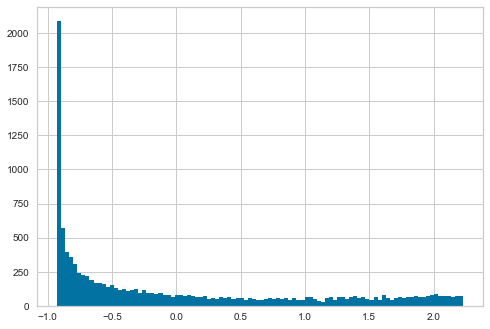

In [20]:
for col in X_scaled_df.columns:
    print(f"{col.upper()}")
    X_scaled_df[col].hist(bins = 100)
    plt.show()

### Show feature distribution per cluster

In [23]:
X_scaled_df_clustered = X_scaled_df.copy()
X_scaled_df_clustered["cluster"] = clusters

cols = ['danceability', 'energy', 'loudness', 'liveness', 'valence', 
                 'tempo', 'acousticness'] # ,'speechiness', 'instrumentalness

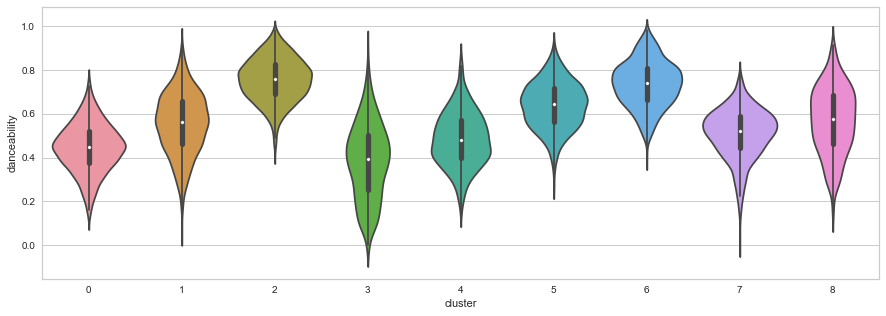

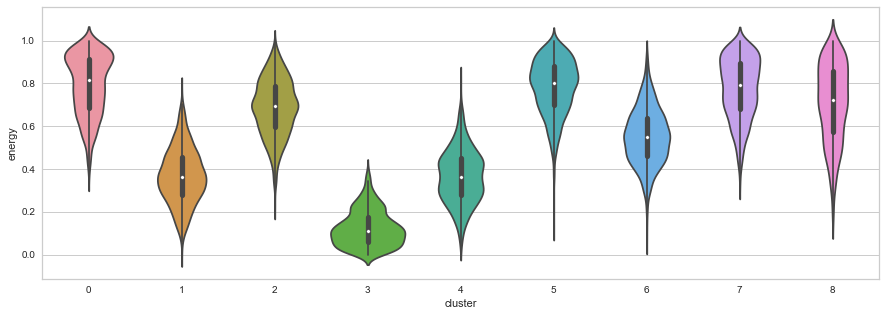

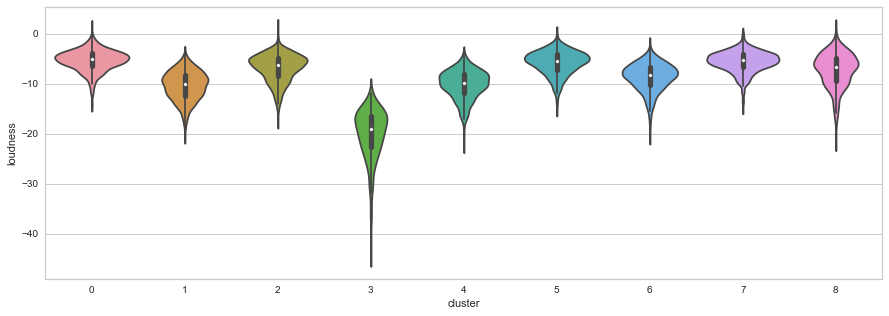

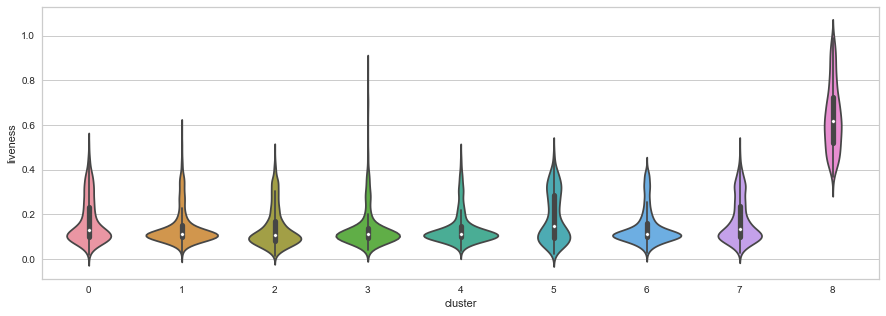

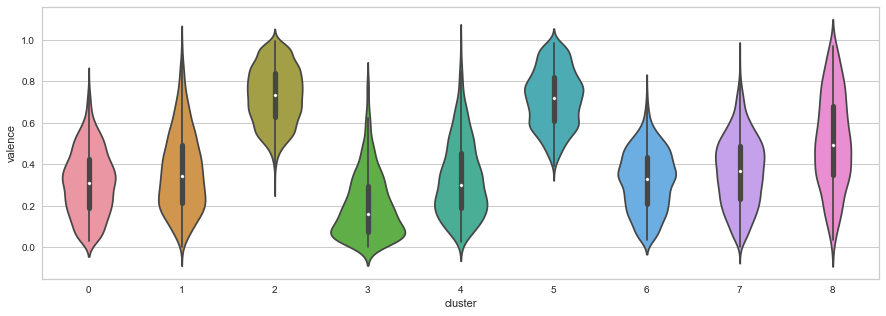

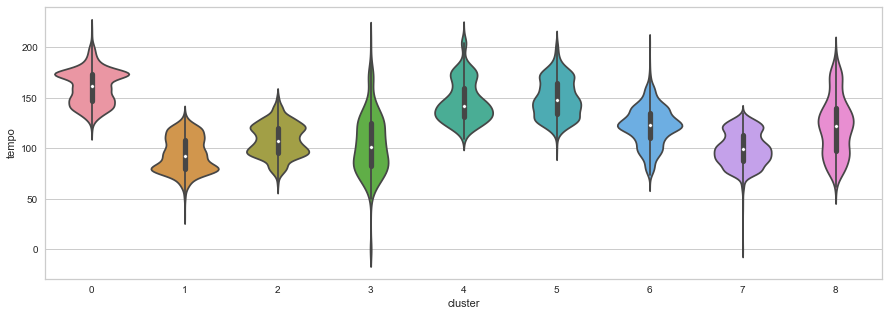

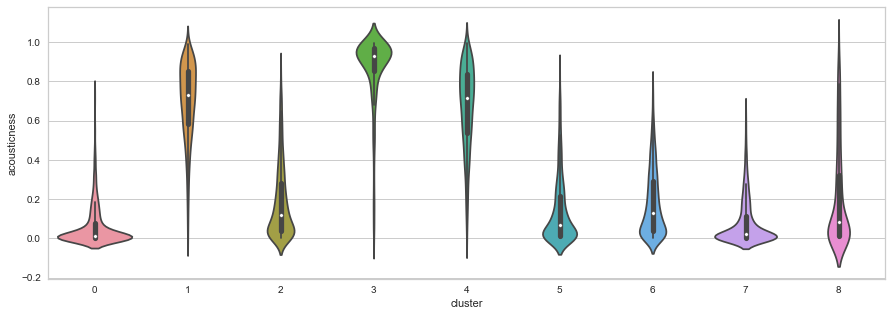

In [24]:
for feature in cols:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.violinplot(y=df_complete[feature], x=df_complete["cluster"], ratio= 3)
    plt.show()


### Show feature distribution across cluster (scales / transformed)

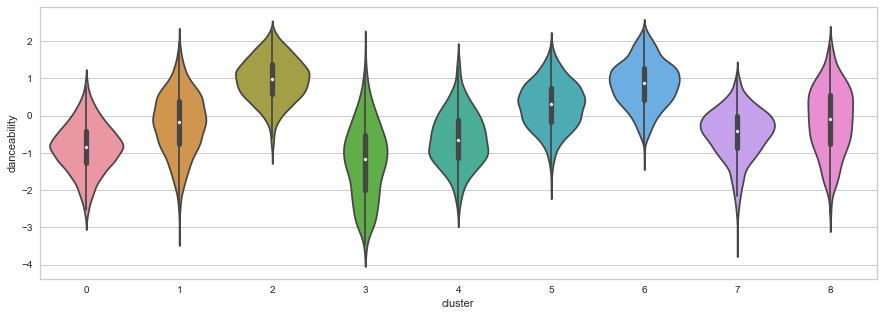

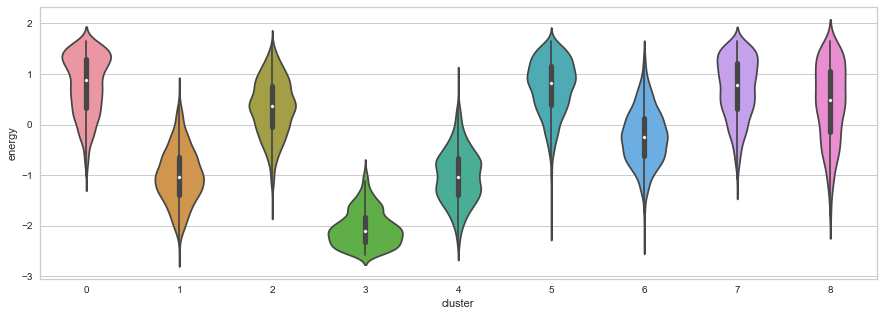

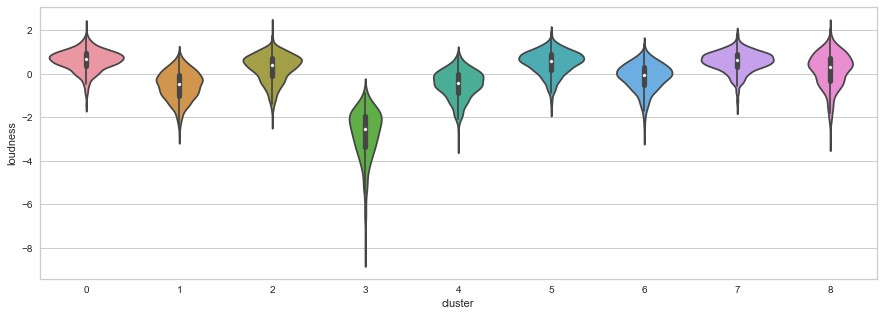

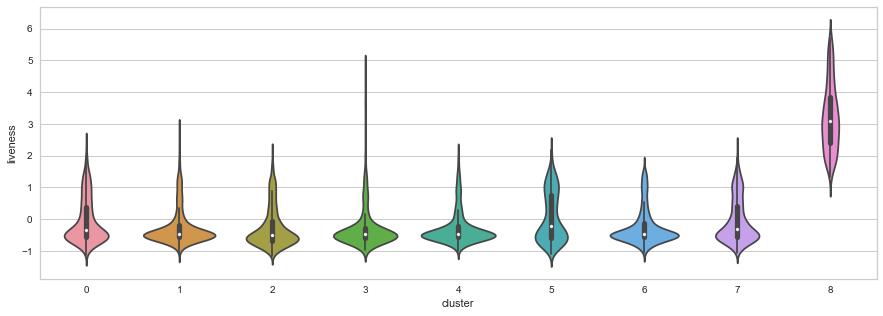

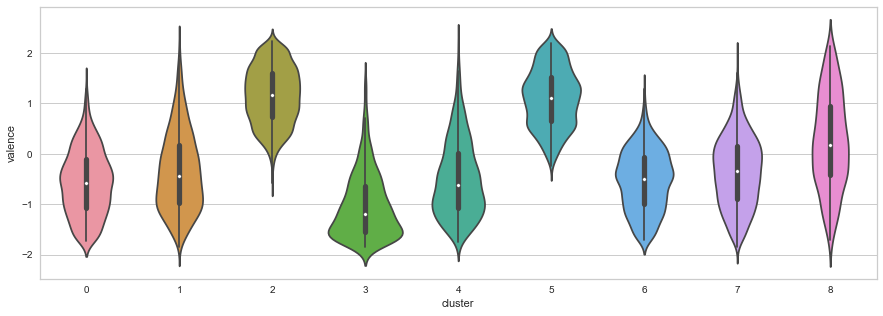

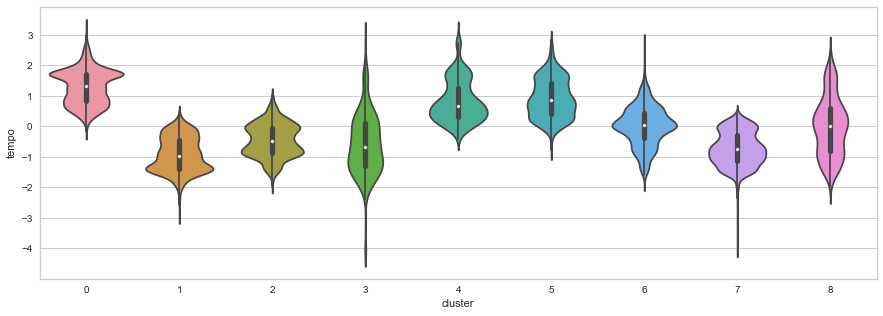

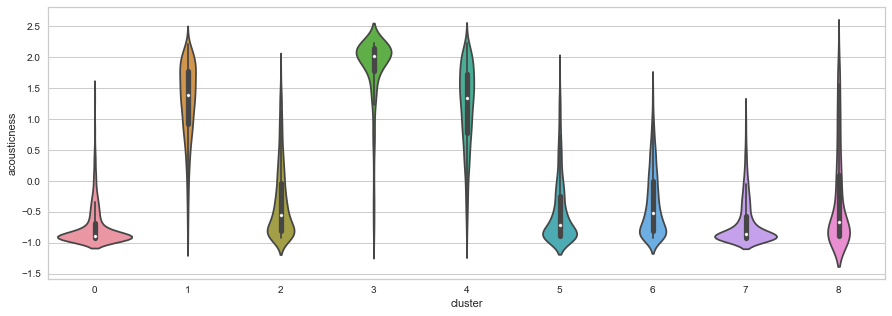

In [25]:
for feature in cols:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.violinplot(y=X_scaled_df_clustered[feature], x=X_scaled_df_clustered["cluster"], ratio= 3)
    plt.show()


### Show feature distribution per cluster (scales / transformed)

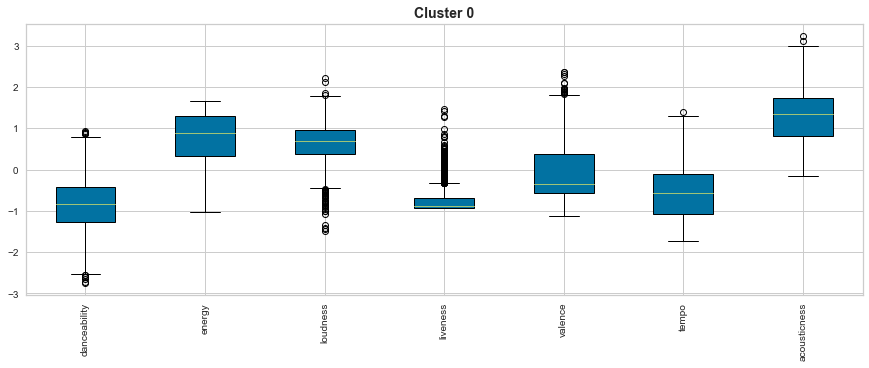

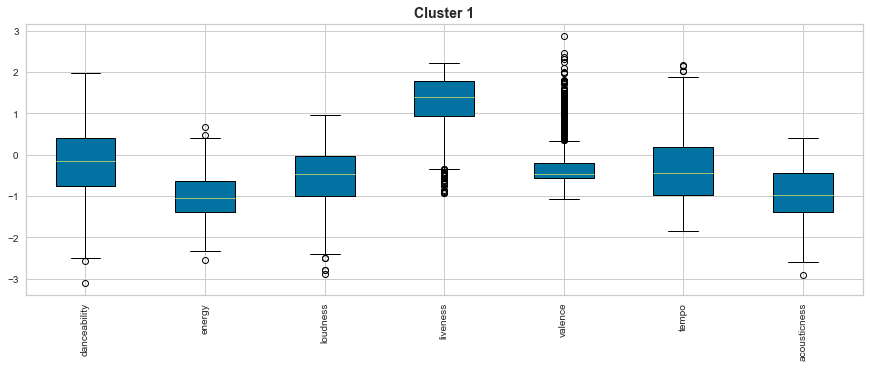

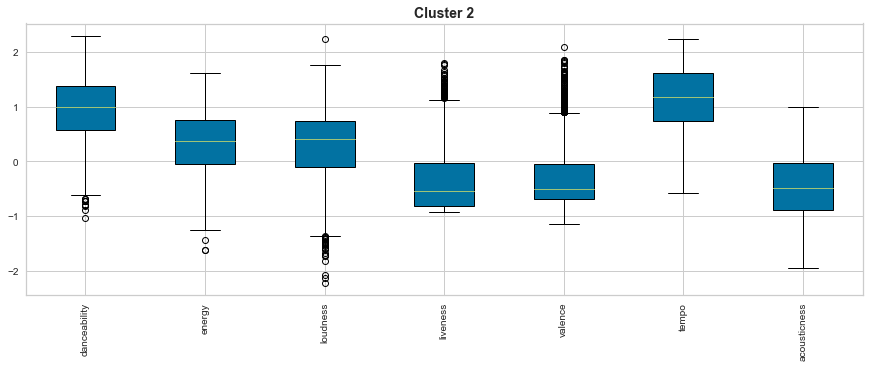

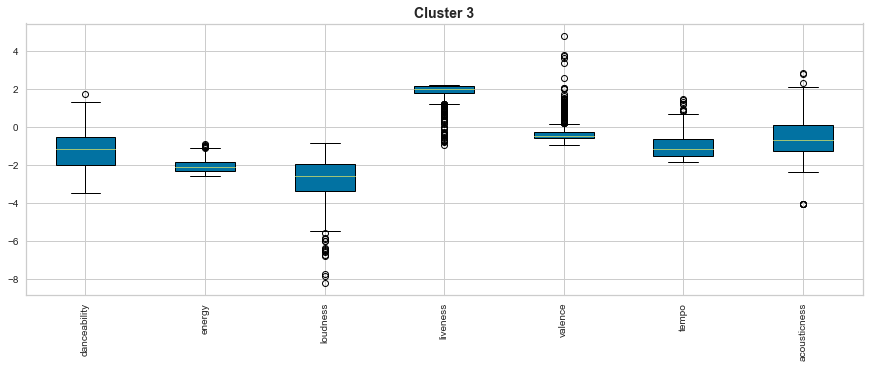

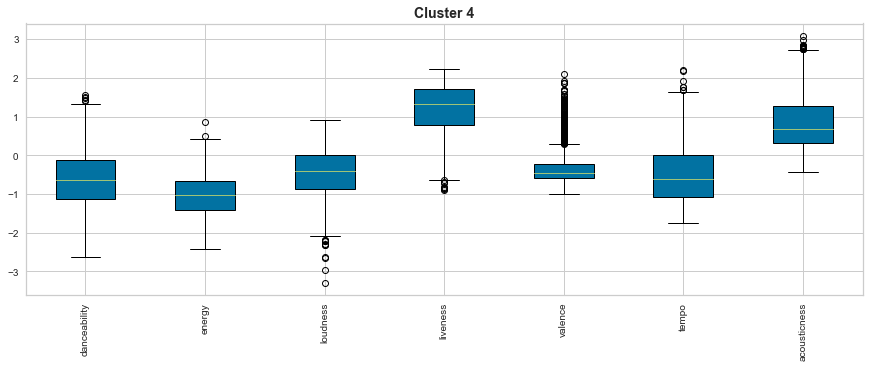

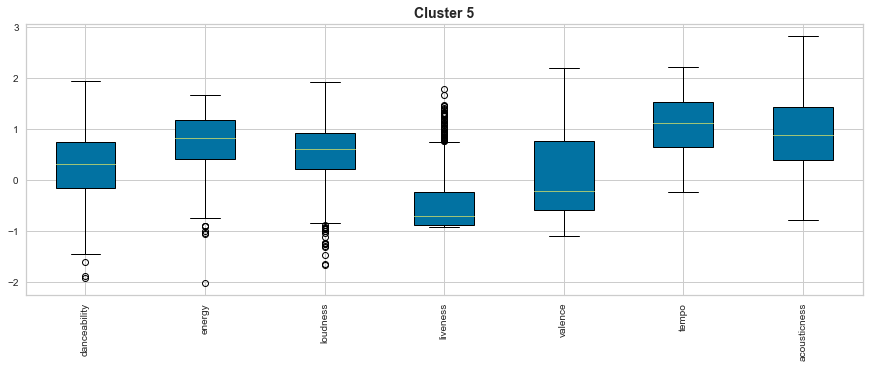

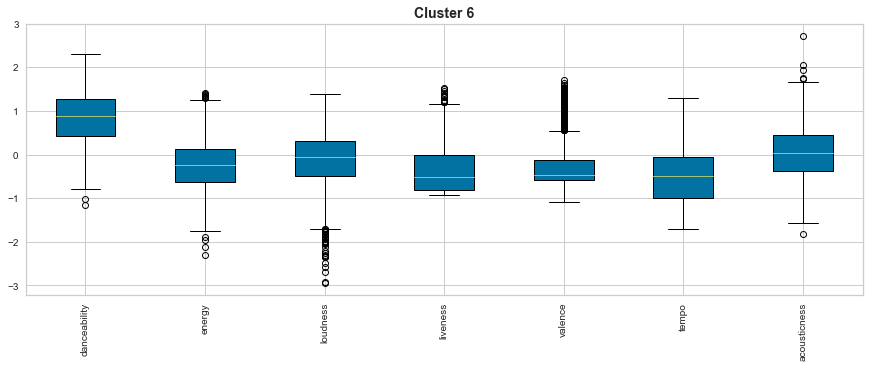

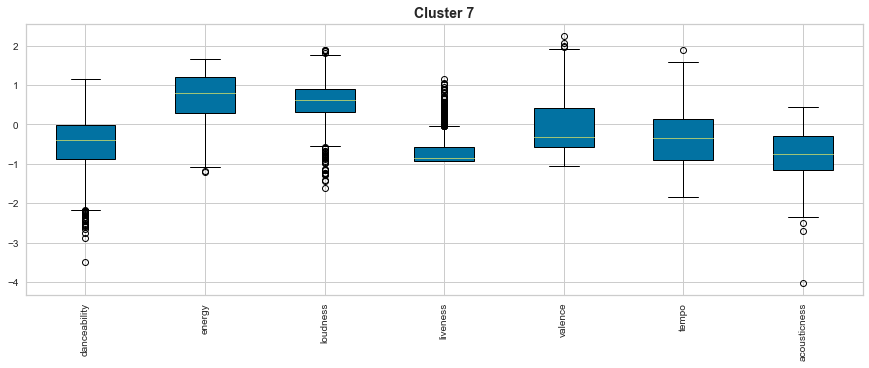

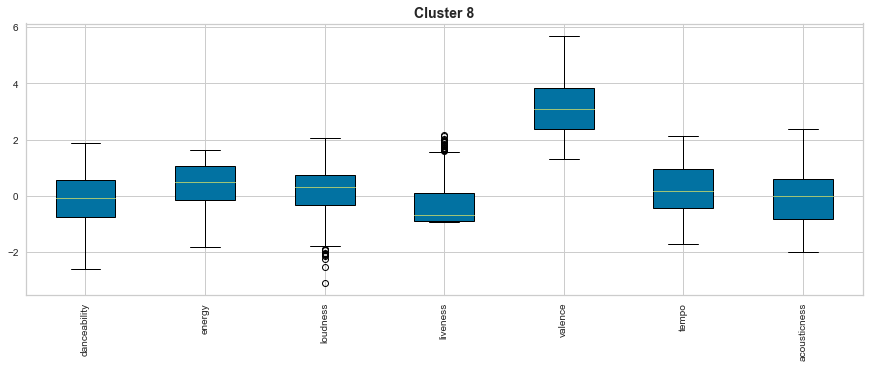

In [27]:
for c in range(len(np.unique(clusters))):
    df = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==c]
    
    dance = df["danceability"].values
    energy = df["energy"].values
    loudness = df["loudness"].values
    #speechiness = df["speechiness"].values
    acousticness = df["acousticness"].values
    #intrumentalness = df["instrumentalness"].values
    liveness = df["liveness"].values
    valence = df["valence"].values
    tempo = df["tempo"].values
    
    all_data = [dance, energy, loudness, acousticness, liveness, valence, tempo] # speechiness, intrumentalness
    
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title(f"Cluster {c}", size=14, weight="bold")
    plt.boxplot(all_data, vert=True, patch_artist=True, labels=cols)     
    plt.xticks(rotation="vertical")
    plt.show()

**For every cluster, kick outliers in each respective feature.**

## Drop Outliers per Features per Cluster, then Recluster with new Model

In [56]:
def remove_outliers_by_IRQ(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis = 1)]
    return df_cleaned

In [81]:
df_cluster_0 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==0]
df_cluster_1 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==1]
df_cluster_2 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==2]
df_cluster_3 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==3]
df_cluster_4 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==4]
df_cluster_5 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==5]
df_cluster_6 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==6]
df_cluster_7 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==7]
df_cluster_8 = X_scaled_df_clustered[X_scaled_df_clustered["cluster"]==8]

df_cluster_all = [df_cluster_0, df_cluster_1, df_cluster_2, df_cluster_3, df_cluster_4, 
                  df_cluster_5, df_cluster_6, df_cluster_7, df_cluster_8]

cols_to_drop_outliers_from = ['danceability', 'energy', 'loudness', 'liveness', 'valence', 'tempo', 'acousticness']

X_scaled_df_reclustered_nofliers = pd.DataFrame()

for df in df_cluster_all:
    df = remove_outliers_by_IRQ(df)
    X_scaled_df_reclustered_nofliers = pd.concat([X_scaled_df_reclustered_nofliers, df])

X_scaled_df_nofliers = X_scaled_df_reclustered_nofliers.copy()
X_scaled_df_nofliers.drop(["cluster"], inplace=True, axis=1)

,danceability,energy,loudness,liveness,valence,tempo,acousticness,cluster
2,-0.895768,1.582006,0.732855,0.515733,-0.953062,1.168243,-0.928828,0
15,0.748887,1.094818,0.908737,-0.349443,-0.340219,1.664845,-0.925152,0
40,-1.779991,0.798269,0.882527,0.164035,-0.496515,1.592314,-0.902366,0
65,-0.571553,1.488805,0.621348,0.747853,-1.570018,1.663952,-0.927292,0
68,-1.662095,0.743195,0.897701,-0.426817,-0.323767,1.789293,-0.478878,0
...,...,...,...,...,...,...,...,...
11082,-1.119771,-0.218472,-0.568670,2.886173,0.836110,-1.207988,-0.666489,8
11085,1.002364,-0.065961,-0.408652,3.033886,-0.488289,0.045727,0.630311,8
11123,-0.689449,-0.205762,-1.407845,4.060843,0.544084,-0.895329,0.848980,8
11124,-0.825030,0.277189,-0.242887,4.349235,0.544084,-0.866938,-0.657299,8


Optimal number of clusters 9


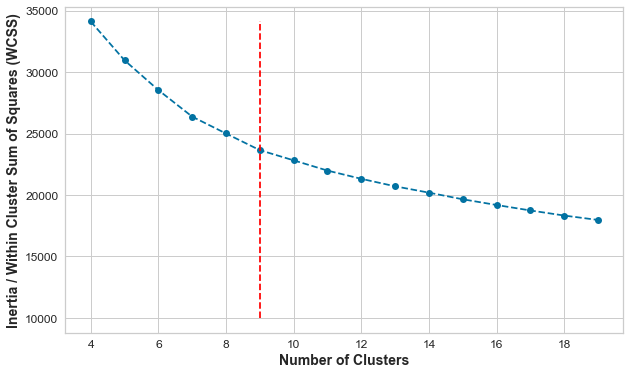

In [71]:
K = list(range(4,20))
inertia = []

for k in K:
    #print("Training a K-Means model with {} clusters! ".format(k))
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(X_scaled_df_nofliers)
    inertia.append(kmeans.inertia_)

cluster_count_new = KneeLocator(K, inertia, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", cluster_count)
    
fig = plt.figure(figsize=(10,6))
plt.plot(K, inertia, marker='o', linestyle='--')
plt.vlines(cluster_count, ymin=10000 , ymax=max(inertia), linestyles='dashed', color="red")
plt.xlabel('Number of Clusters', weight="bold", fontsize=14)
plt.ylabel('Inertia / Within Cluster Sum of Squares (WCSS)', weight="bold", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [94]:
kmeans_new = KMeans(n_clusters = cluster_count_new, random_state = 1234)
kmeans_new.fit(X_scaled_df_nofliers)
clusters = kmeans_new.predict(X_scaled_df_nofliers)

X_scaled_df_nofliers["cluster"] = clusters

X_scaled_df_nofliers_complete = pd.merge(df_complete[["song_name", "song_artist", "id"]], X_scaled_df_nofliers, left_index=True, right_index=True)

song_collection_clustered_title = model_path + "/" + str(len(df_complete)) + "_Song_Collection_noFliers_reCLUSTERED.csv"
X_scaled_df_nofliers_complete.to_csv(song_collection_clustered_title, index=False)